# Description

The notebook automates the process of pushing a pair of scenarios (baseline and alternative) through the simulation and optimization pipeline, comparing outputs for each scenario. Key outputs include harvested area (hectares), harvested volume (m³), and growth (m³). The notebook also reports stand age class distribution, old growth attributes, and tree species diversity at the beginning and end of the planning horizon for each scenario. Additionally, it calculates biodiversity and socioeconomic indicators, while quantifying differences between baseline and alternative scenarios in terms of carbon stocks and net emissions over a customizable simulation horizon, set to 100 years by default (the system can easily be parametrized to simulate shorter or longer horizons).

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
# Initialize the input parameters
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
# scenario_options = {
#     'redchris': ['no_cons','evenflow_cons',  'bau_redchrs', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
#     'goldenbear': ['no_cons', 'evenflow_cons', 'bau_gldbr', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
#     'equitysilver': [ 'no_cons','evenflow_cons', 'bau_eqtslvr', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
#     'test': ['evenflow_cons']
# }

scenario_options = {

    'test': ['evenflow_cons']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
# case_study_dropdown = widgets.Dropdown(
#     options=['redchris', 'goldenbear', 'equitysilver', 'test'],
#     value='test',
#     description='Case Study:'
# )

case_study_dropdown = widgets.Dropdown(
    options=['test'],
    value='test',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['test'],  # Set initial options based on default case study
    value=scenario_options['test'][0],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', options=('test',), value='test')

Dropdown(description='Scenario:', options=('evenflow_cons',), value='evenflow_cons')

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
hwp_pool_effect_value

0.0

In [8]:
obj_mode

'min_em'

In [9]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'test': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [10]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [11]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [12]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [13]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [14]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [15]:
# Read carbon curves
# file_directory = "./data/curves"
file_names = ["pi.csv", "fi.csv"]
# loaded_data = {}
file_path = ["./data/curves/pi.csv", "./data/curves/fi.csv"] 
pi = pd.read_csv(file_path[0], index_col=0)
fi = pd.read_csv(file_path[1], index_col=0)
# for filename in file_names:
#     file_path = os.path.join(file_directory, filename)
#     with open(file_path, 'rb') as file:
#         loaded_data[filename] = pickle.load(file)
#     print(f"Loaded data from {file_path}")

# c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
# c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

In [16]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [17]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [18]:
c_curves_f['total_emission'] = 44/12 * c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [19]:
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [20]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for test_min_em_evenflow_cons...
running even flow constraints scenario
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/187b1dfe6bc8431dba48d62fdb449c88-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/187b1dfe6bc8431dba48d62fdb449c88-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 610 COLUMNS
At line 39015 RHS
At line 39621 BOUNDS
At line 43232 ENDATA
Problem MODEL has 605 rows, 3610 columns and 34794 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 313 (-292) rows, 3322 (-288) columns and 32354 (-2440) elements
0  Obj -2044627.6 Primal inf 367.03658 (278) Dual inf 13377972 (278)
Optimal - objective value -4394696
After Postsolve, objective -4394696, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -4394695.993 

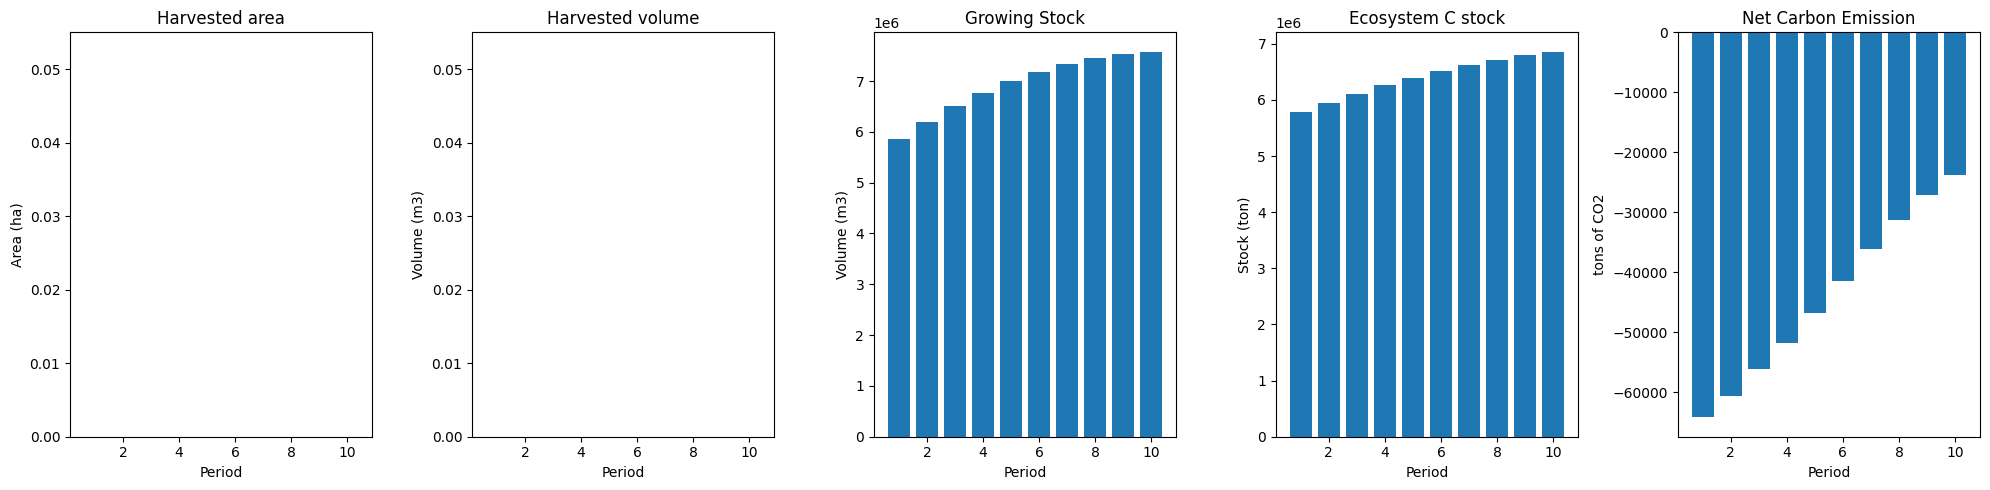

Plot saved to ./outputs/fig/test/test_min_em_evenflow_cons_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


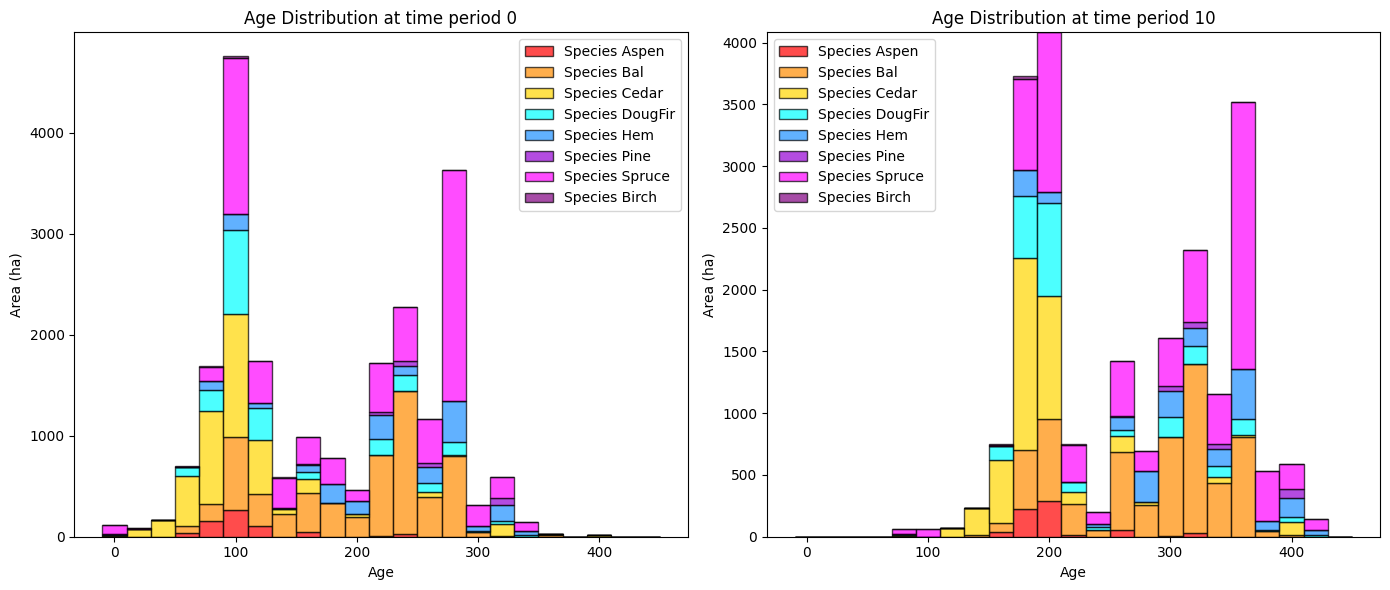

Plot saved to ./outputs/fig/test/test_min_em_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Aspen      42.290489   519.192325   476.901835
Pine      156.364968   204.552976    48.188007
Spruce   4471.720232  7098.592523  2626.872291
Hem      1246.520025  1621.166502   374.646477
Birch       3.090902    40.119295    37.028393
Cedar     283.576558  2289.652623  2006.076065
DougFir   504.920628  1597.575721  1092.655093
Bal      3699.410838  5331.685081  1632.274244

Old growth has **increased** by 8294.64 hectares from time period 0 to time period 10.


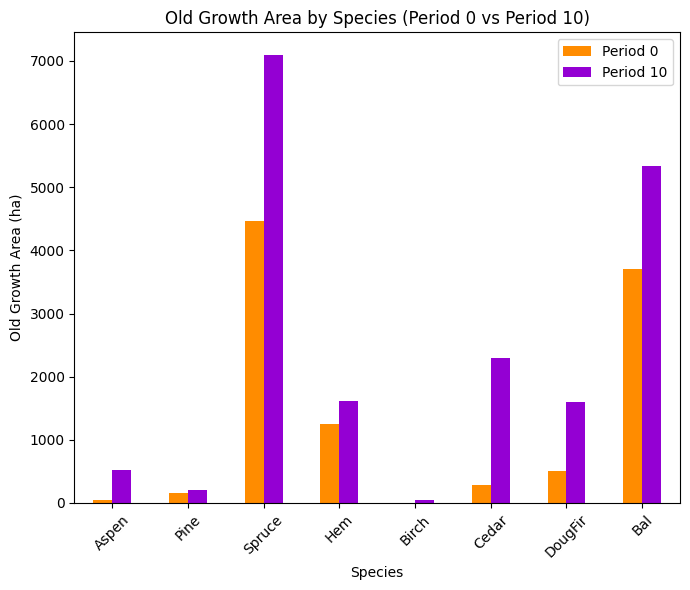

Clustered column plot saved to ./outputs/fig/test/test_min_em_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7329
Shannon Evenness Index for time period 10: 0.7395

Diversity has **increased** by 0.66% from time 0 to time 10.


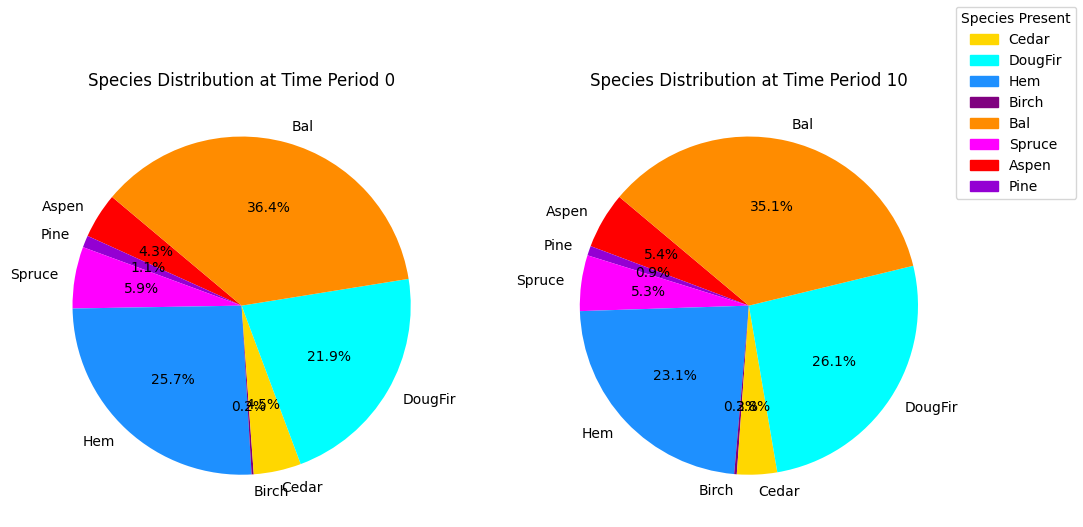

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/test/test_min_em_evenflow_cons_species_pie.pdf
running no_cons scenario
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/1d083c6793a946f3ad26a10ab8d05752-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/1d083c6793a946f3ad26a10ab8d05752-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 570 COLUMNS
At line 7791 RHS
At line 8357 BOUNDS
At line 11968 ENDATA
Problem MODEL has 565 rows, 3610 columns and 3610 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-565) rows, 0 (-3610) columns and 0 (-3610) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value -4394696
After Postsolve, objective -4394696, infeasibilities - dual 0 (0), primal 0 (0)
Optimal ob

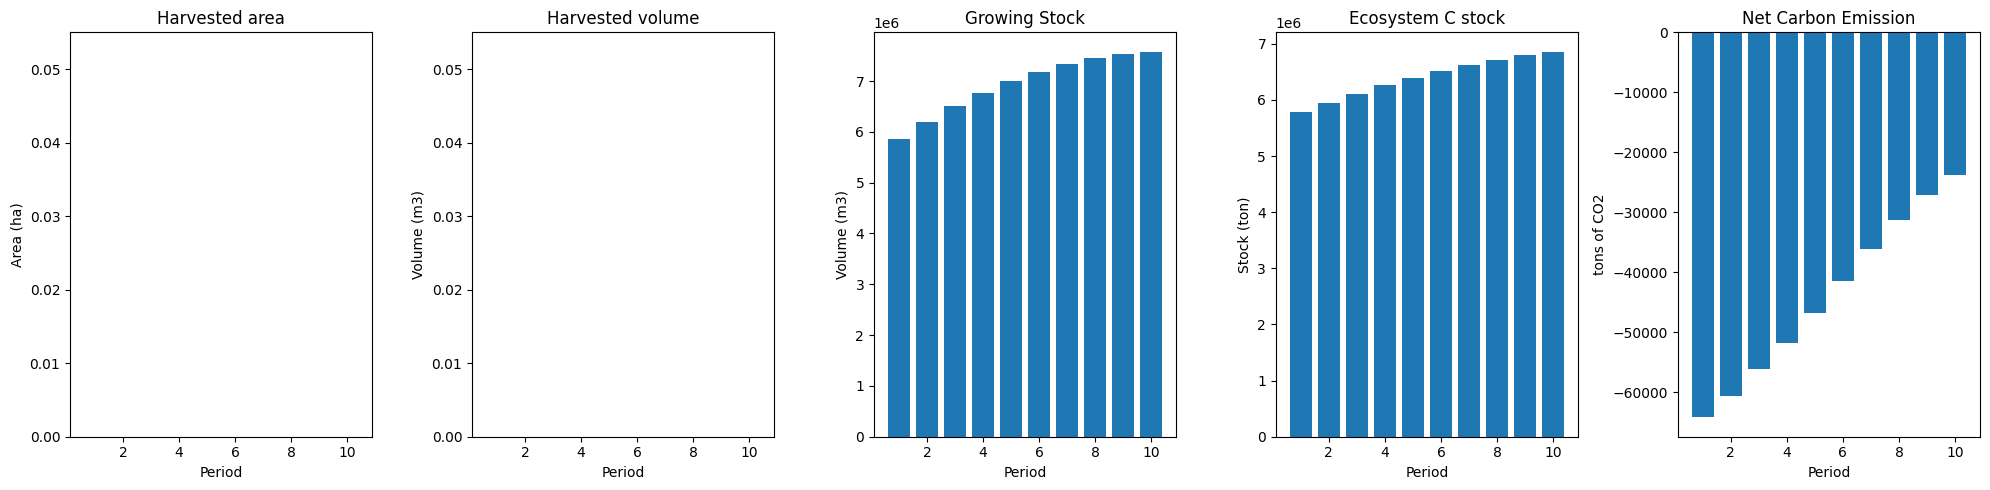

Plot saved to ./outputs/fig/test/test_min_em_no_cons_scheduling_minemission.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


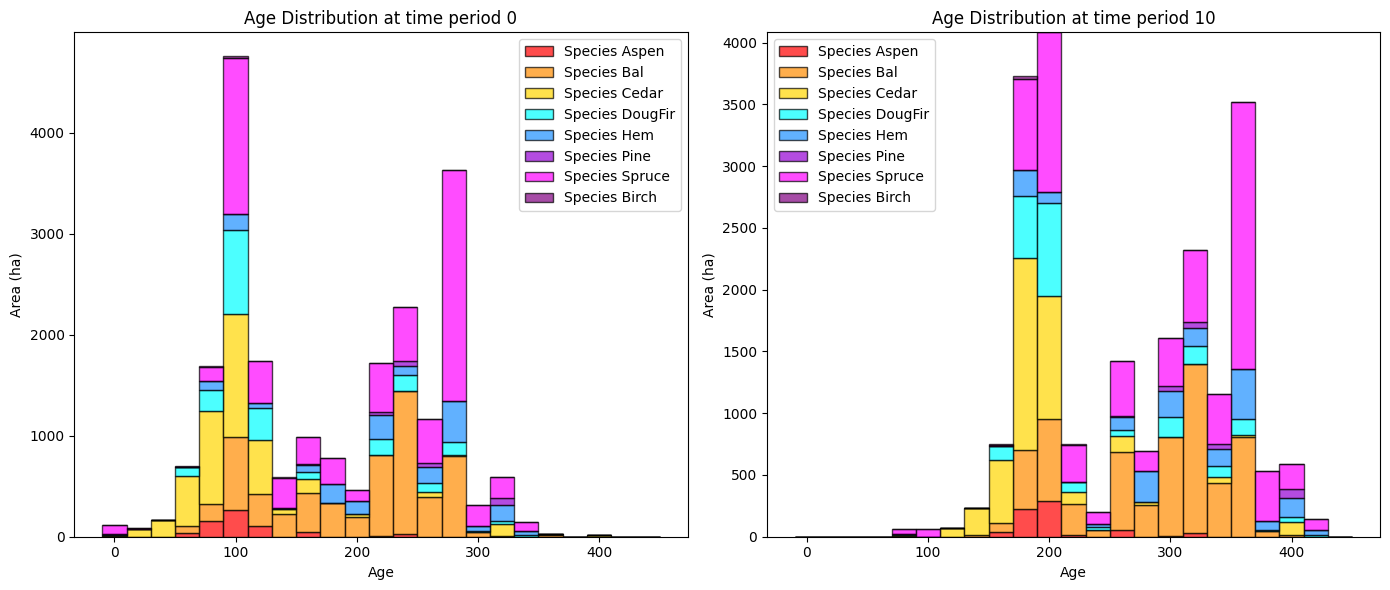

Plot saved to ./outputs/fig/test/test_min_em_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Aspen      42.290489   519.192325   476.901835
Pine      156.364968   204.552976    48.188007
Spruce   4471.720232  7098.592523  2626.872291
Hem      1246.520025  1621.166502   374.646477
Birch       3.090902    40.119295    37.028393
Cedar     283.576558  2289.652623  2006.076065
DougFir   504.920628  1597.575721  1092.655093
Bal      3699.410838  5331.685081  1632.274244

Old growth has **increased** by 8294.64 hectares from time period 0 to time period 10.


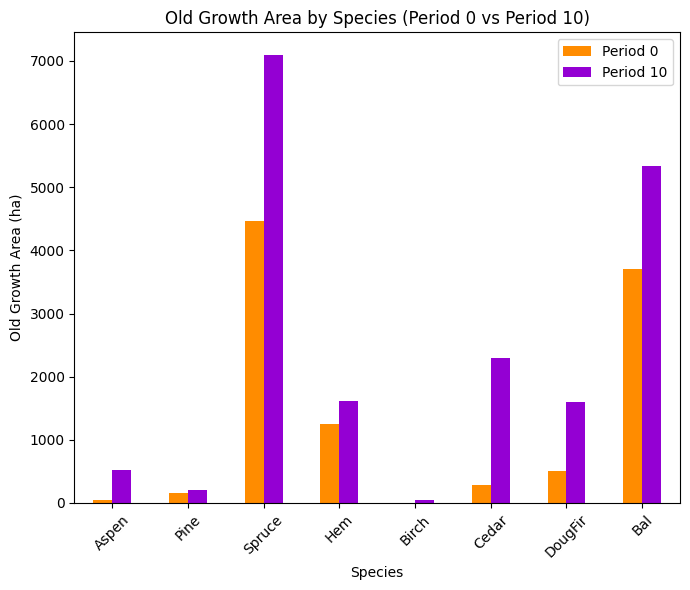

Clustered column plot saved to ./outputs/fig/test/test_min_em_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7329
Shannon Evenness Index for time period 10: 0.7395

Diversity has **increased** by 0.66% from time 0 to time 10.


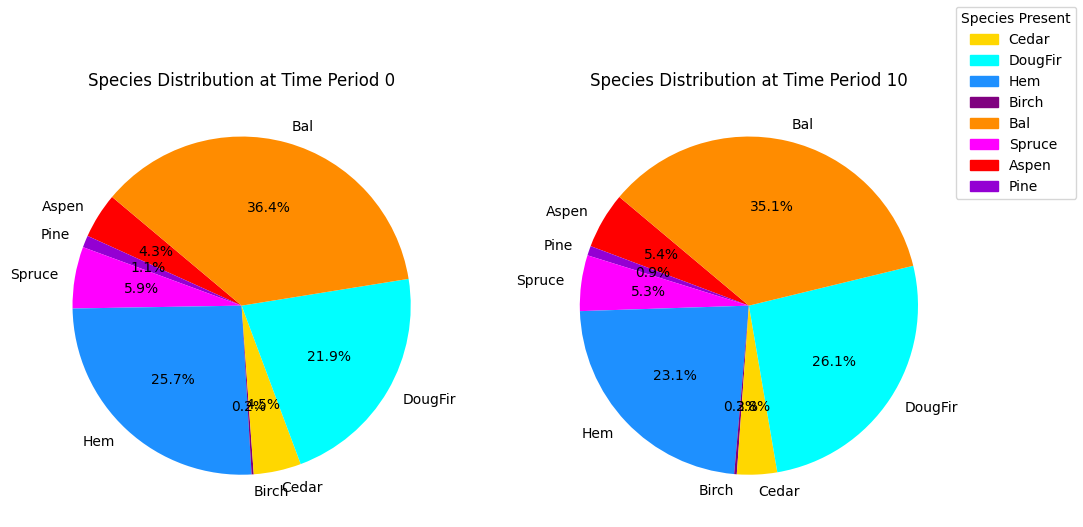

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/test/test_min_em_no_cons_species_pie.pdf


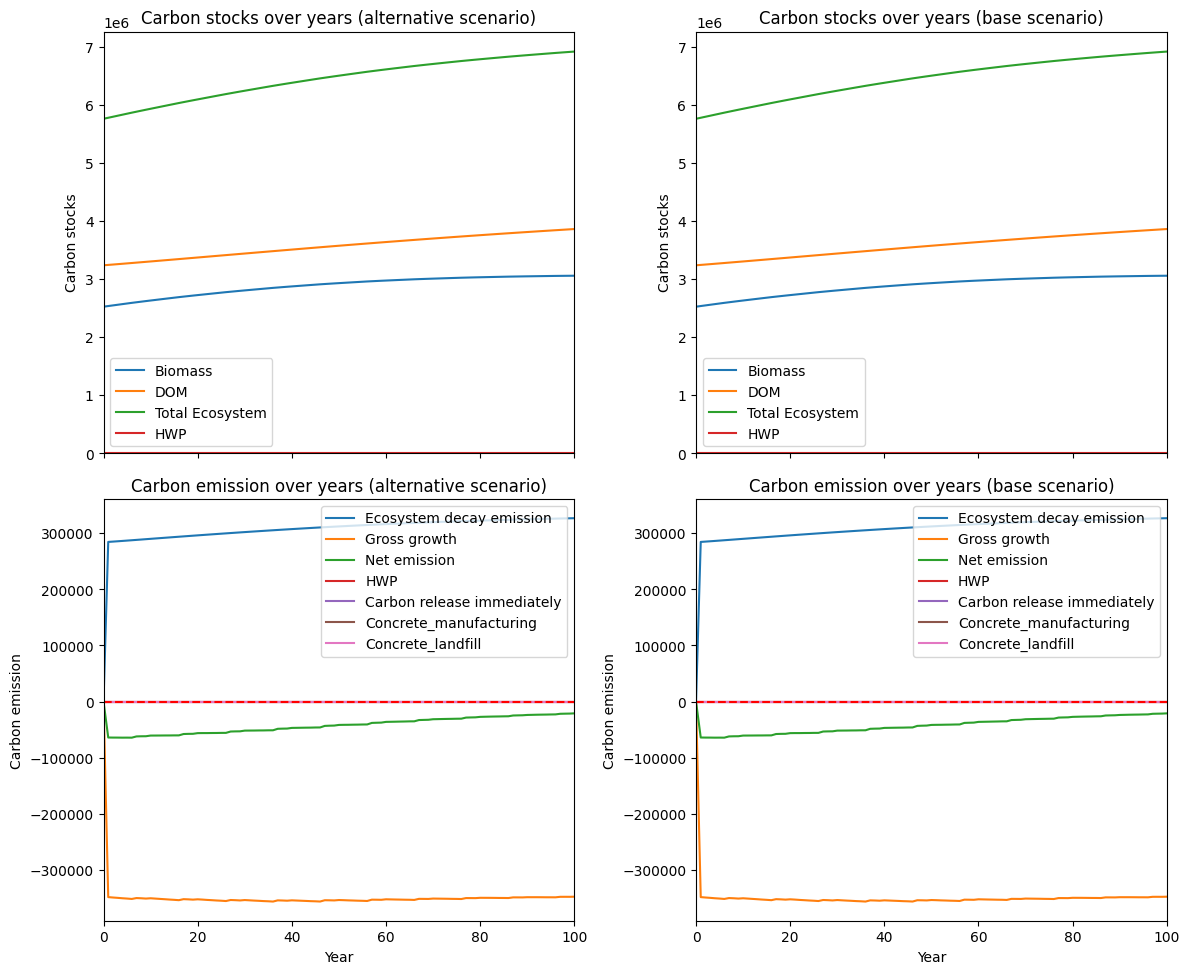

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -4245783.917248338
Net emission alternative scenario -4245783.917248338
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
           0   10  Difference
Aspen    0.0  0.0         0.0
Pine     0.0  0.0         0.0
Spruce   0.0  0.0         0.0
Hem      0.0  0.0         0.0
Birch    0.0  0.0         0.0
Cedar    0.0  0.0         0.0
DougFir  0.0  0.0         0.0
Bal      0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/sghotb/ecotrust-dss-/util.py:1298: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario['Net emission'].sum()) # Calculate for the next 25 years


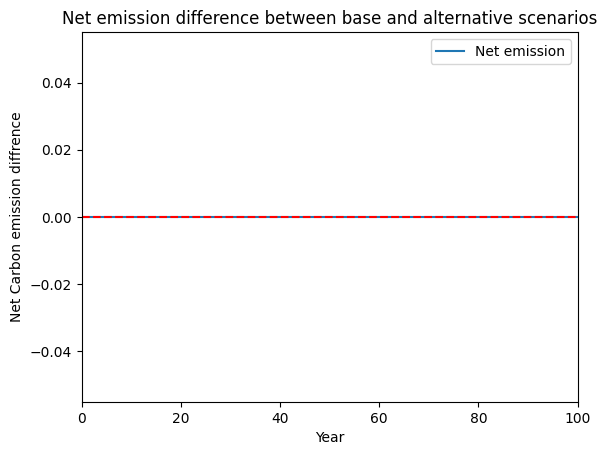

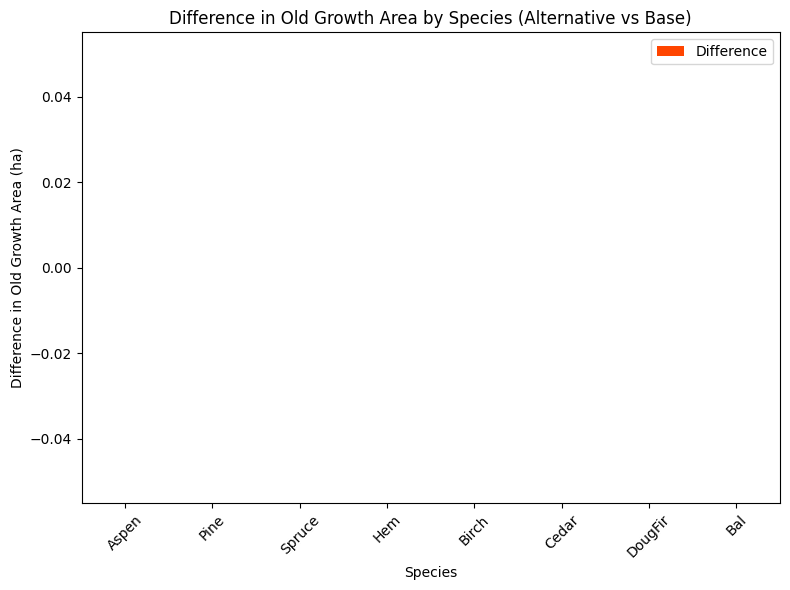

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/test/test_min_em_kpi_age_difference.pdf


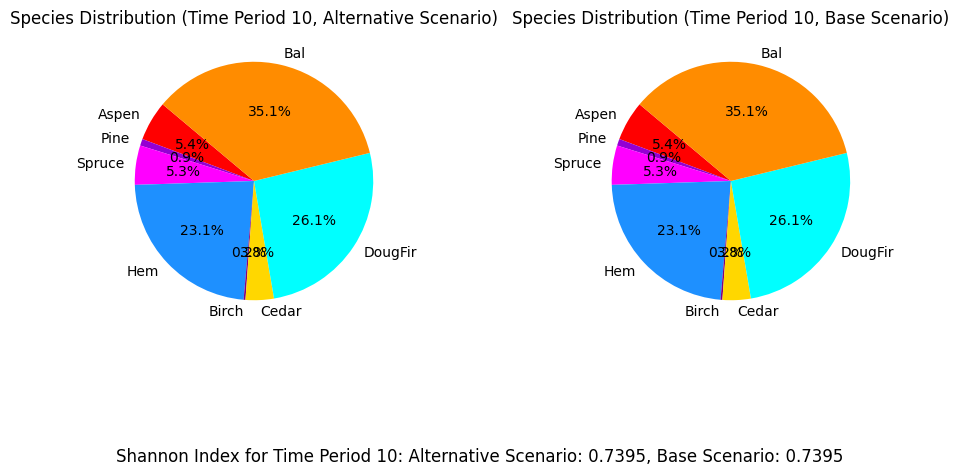

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/test/test_min_em_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 1.3 minutes to run all scenarios.


In [21]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")